### Imports

In [0]:
from fastai2.vision.all import *
from fastai2.callback.tracker import SaveModelCallback

from sklearn.model_selection import StratifiedKFold

In [0]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(2020)

In [0]:
test_dir = Path('ICLR/test/test/')
train_dir = Path('ICLR/train/train/')

In [4]:
train_dir.ls()

(#3) [Path('ICLR/train/train/healthy_wheat'),Path('ICLR/train/train/stem_rust'),Path('ICLR/train/train/leaf_rust')]

In [5]:
all_trn_images = get_image_files(train_dir).sorted()
all_trn_images

(#876) [Path('ICLR/train/train/healthy_wheat/03TD19.jpg'),Path('ICLR/train/train/healthy_wheat/0LBIWV.jpg'),Path('ICLR/train/train/healthy_wheat/0O5BON.jpg'),Path('ICLR/train/train/healthy_wheat/0PFX47.jpg'),Path('ICLR/train/train/healthy_wheat/1LNMUQ.jpg'),Path('ICLR/train/train/healthy_wheat/1NX3ZC.jpg'),Path('ICLR/train/train/healthy_wheat/2KS7HG.jpg'),Path('ICLR/train/train/healthy_wheat/33J5MM.jpg'),Path('ICLR/train/train/healthy_wheat/341R1E.jpg'),Path('ICLR/train/train/healthy_wheat/3C82ZM.jpg')...]

In [6]:
train_df = pd.DataFrame(all_trn_images)
train_df.columns = ['fn']
train_df['label'] = train_df.fn.apply(parent_label)
train_df = train_df.sample(frac=1.0, random_state=42)
train_df.reset_index(drop=True, inplace=True)
train_df.head()

,fn,label
0,ICLR/train/train/leaf_rust/MAPKID.jpg,leaf_rust
1,ICLR/train/train/stem_rust/DNG7B7.JPG,stem_rust
2,ICLR/train/train/stem_rust/V2K7M9.jpg,stem_rust
3,ICLR/train/train/stem_rust/GZ3DJ9.jpg,stem_rust
4,ICLR/train/train/leaf_rust/7KMEN7.jpg,leaf_rust


In [0]:
test_files = get_image_files(test_dir).sorted()

### Split data - StratifiedKFold

In [0]:
NFOLDS = 5
skf = StratifiedKFold(n_splits=NFOLDS, shuffle=False)

In [9]:
fold_to_val_idx = {}

for i, (trn_idx, val_idx) in enumerate(skf.split(train_df.fn, train_df.label)):
  print(val_idx[:5])
  fold_to_val_idx[i] = val_idx

[0 1 2 3 4]
[159 160 165 168 171]
[321 326 327 330 333]
[478 487 490 495 507]
[693 694 700 701 702]


### Training model

In [10]:
fold = 0
val_idx = fold_to_val_idx[fold]
print(len(val_idx), val_idx[:5])

176 [0 1 2 3 4]


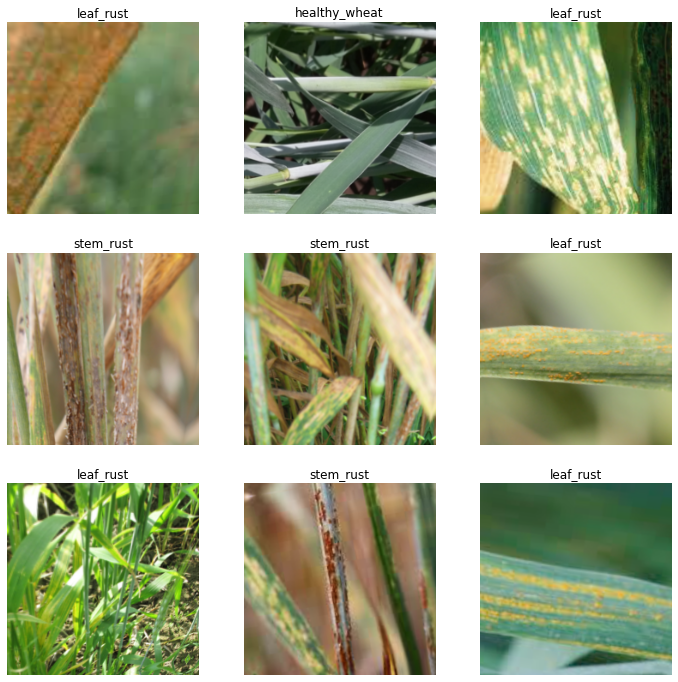

In [11]:
def get_dls(img_sz, bs):
  wheat = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_x=lambda o: o.fn,
                  get_y=lambda o: o.label, 
                  splitter=IndexSplitter(val_idx),
                  item_tfms=RandomResizedCrop(img_sz),
                  batch_tfms=aug_transforms(flip_vert=True))
  return wheat.dataloaders(train_df, bs=bs)

dls = get_dls(224, 32)
dls.train.show_batch(max_n=9, figsize=(12,12))

In [12]:
cbs = [SaveModelCallback(monitor='accuracy')]
learn = cnn_learner(dls, densenet201, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.494388,0.943278,0.664773,01:29
1,1.350673,0.857227,0.721591,01:25
2,1.171519,0.728043,0.778409,01:23
3,1.050260,0.748384,0.727273,01:23


In [13]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.893162,0.893168,0.772727,01:25
1,0.954779,1.301748,0.693182,01:23
2,0.932952,0.914591,0.789773,01:23
3,0.855249,0.594820,0.840909,01:23
4,0.781506,0.580026,0.857955,01:23


In [14]:
learn.dls = get_dls(299, 24)
learn.freeze()
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.708167,0.707079,0.840909,01:33
1,0.757071,0.650178,0.835227,01:25
2,0.715126,0.606361,0.863636,01:26
3,0.682260,0.585531,0.869318,01:26


In [15]:
learn.unfreeze()
learn.fit_one_cycle(10, lr_max=slice(1e-4,1e-3), cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.618459,0.559641,0.880682,01:27
1,0.676128,0.941441,0.806818,01:27
2,0.709287,0.865302,0.806818,01:27
3,0.739652,0.689727,0.857955,01:27
4,0.703701,0.569493,0.869318,01:26
5,0.653820,0.536946,0.897727,01:25
6,0.607175,0.489039,0.903409,01:29
7,0.564719,0.486858,0.903409,01:27
8,0.550675,0.474441,0.897727,01:27
9,0.535542,0.478231,0.897727,01:31


### Prediction

In [17]:
test_dl = learn.dls.test_dl(test_files)
preds,_ = learn.get_preds(dl=test_dl)

In [18]:
sub_df = pd.DataFrame(preds)
sub_df.columns = dls.vocab
sub_df['ID'] = test_files
sub_df['ID'] = sub_df.ID.apply(lambda x: x.stem)

sub_df = sub_df[['ID', 'leaf_rust', 'stem_rust', 'healthy_wheat']]
sub_df.to_csv(f'submission_fold_{fold}.csv', index=False)
sub_df.head()

,ID,leaf_rust,stem_rust,healthy_wheat
0,008FWT,0.696605,0.269084,0.034311
1,00AQXY,0.061044,0.908661,0.030295
2,01OJZX,0.696605,0.269084,0.034311
3,07OXKK,0.007431,0.004932,0.987637
4,085IEC,0.036555,0.046759,0.916686
